In [1]:

%%capture
!pip install statsmodels
!pip install torch
!pip install scikit-learn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

### Import Data

In [4]:
df = pd.read_csv('/kaggle/input/gold-prices-for-5-years-financial-predictions/Gold  Prices.csv')
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
0,2019-11-11 00:00:00-05:00,137.610001,137.789993,136.440002,137.059998,7037300,0.0,0.0,0.0
1,2019-11-12 00:00:00-05:00,137.029999,137.589996,136.190002,137.429993,6448600,0.0,0.0,0.0
2,2019-11-13 00:00:00-05:00,137.800003,138.220001,137.639999,137.979996,8776000,0.0,0.0,0.0
3,2019-11-14 00:00:00-05:00,138.389999,138.940002,137.869995,138.559998,5220500,0.0,0.0,0.0
4,2019-11-15 00:00:00-05:00,138.029999,138.419998,137.970001,138.210007,10106700,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1253,2024-11-04 00:00:00-05:00,253.320007,253.580002,252.270004,252.830002,4581400,0.0,0.0,0.0
1254,2024-11-05 00:00:00-05:00,253.779999,253.990005,252.410004,253.399994,6029900,0.0,0.0,0.0
1255,2024-11-06 00:00:00-05:00,245.639999,247.350006,244.949997,245.699997,14600200,0.0,0.0,0.0
1256,2024-11-07 00:00:00-05:00,248.289993,250.240005,248.119995,249.649994,8821400,0.0,0.0,0.0


In [5]:
import pandas as pd


df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
df['Date'] = df['Date'].dt.tz_convert(None).dt.normalize()

In [6]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
0,2019-11-11,137.610001,137.789993,136.440002,137.059998,7037300,0.0,0.0,0.0
1,2019-11-12,137.029999,137.589996,136.190002,137.429993,6448600,0.0,0.0,0.0
2,2019-11-13,137.800003,138.220001,137.639999,137.979996,8776000,0.0,0.0,0.0
3,2019-11-14,138.389999,138.940002,137.869995,138.559998,5220500,0.0,0.0,0.0
4,2019-11-15,138.029999,138.419998,137.970001,138.210007,10106700,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1253,2024-11-04,253.320007,253.580002,252.270004,252.830002,4581400,0.0,0.0,0.0
1254,2024-11-05,253.779999,253.990005,252.410004,253.399994,6029900,0.0,0.0,0.0
1255,2024-11-06,245.639999,247.350006,244.949997,245.699997,14600200,0.0,0.0,0.0
1256,2024-11-07,248.289993,250.240005,248.119995,249.649994,8821400,0.0,0.0,0.0


### Drop the last 3 columns

In [7]:
df = df[['Date','Open', 'High', 'Low', 'Close', 'Volume']]
df

,Date,Open,High,Low,Close,Volume
0,2019-11-11,137.610001,137.789993,136.440002,137.059998,7037300
1,2019-11-12,137.029999,137.589996,136.190002,137.429993,6448600
2,2019-11-13,137.800003,138.220001,137.639999,137.979996,8776000
3,2019-11-14,138.389999,138.940002,137.869995,138.559998,5220500
4,2019-11-15,138.029999,138.419998,137.970001,138.210007,10106700
...,...,...,...,...,...,...
1253,2024-11-04,253.320007,253.580002,252.270004,252.830002,4581400
1254,2024-11-05,253.779999,253.990005,252.410004,253.399994,6029900
1255,2024-11-06,245.639999,247.350006,244.949997,245.699997,14600200
1256,2024-11-07,248.289993,250.240005,248.119995,249.649994,8821400


### Check null, duplicate

In [8]:
# check null
null_counts = df.isnull().sum()
print(null_counts)

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [9]:
# check if duplicate
df.duplicated().sum()

0

In [10]:
df


,Date,Open,High,Low,Close,Volume
0,2019-11-11,137.610001,137.789993,136.440002,137.059998,7037300
1,2019-11-12,137.029999,137.589996,136.190002,137.429993,6448600
2,2019-11-13,137.800003,138.220001,137.639999,137.979996,8776000
3,2019-11-14,138.389999,138.940002,137.869995,138.559998,5220500
4,2019-11-15,138.029999,138.419998,137.970001,138.210007,10106700
...,...,...,...,...,...,...
1253,2024-11-04,253.320007,253.580002,252.270004,252.830002,4581400
1254,2024-11-05,253.779999,253.990005,252.410004,253.399994,6029900
1255,2024-11-06,245.639999,247.350006,244.949997,245.699997,14600200
1256,2024-11-07,248.289993,250.240005,248.119995,249.649994,8821400


### A little EDA

In [11]:
df.loc[:, 'Date'] = pd.to_datetime(df['Date'], errors='coerce') 
df.set_index('Date', inplace=True)

In [12]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2019-11-11,137.610001,137.789993,136.440002,137.059998,7037300
2019-11-12,137.029999,137.589996,136.190002,137.429993,6448600
2019-11-13,137.800003,138.220001,137.639999,137.979996,8776000
2019-11-14,138.389999,138.940002,137.869995,138.559998,5220500
2019-11-15,138.029999,138.419998,137.970001,138.210007,10106700
...,...,...,...,...,...
2024-11-04,253.320007,253.580002,252.270004,252.830002,4581400
2024-11-05,253.779999,253.990005,252.410004,253.399994,6029900
2024-11-06,245.639999,247.350006,244.949997,245.699997,14600200


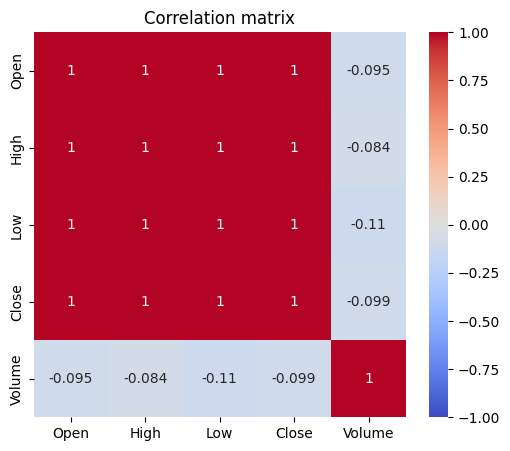

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df[["Open", "High", "Low", "Close", "Volume"]].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix")
plt.show()


#### As you can see:
- The correlation coeff between Close, High, Low, Open is 1, it means that they all go together.
- The correlation between Close, High, Low, Open and Volume is really low, It means that they seem to have no correlation with the volume.

-> to forecast the gold price in the future, i'll only use the Close column.

<Axes: xlabel='Date'>

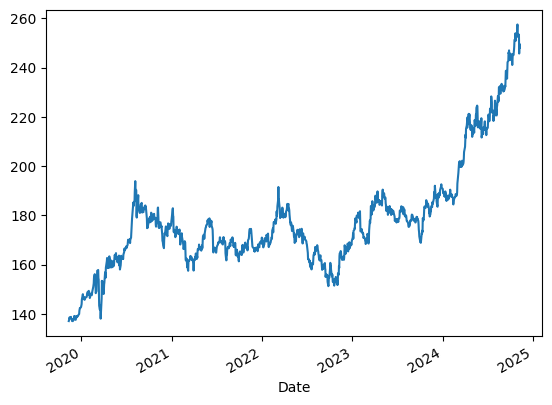

In [14]:
df['Close'].plot()

#### From the chart:
- The gold price grows over time despite some dips.
- From late 2023, it rises sharply and reaches the highest point in 2024.

For more information, lets decompose it!

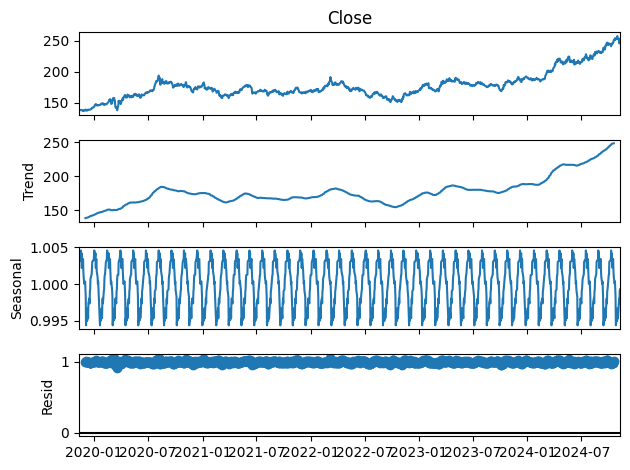

In [15]:
result = seasonal_decompose(df["Close"], model="multiplicative", period=30)
result.plot()
plt.show()

### Create windows
- Window: Basically, it's time in the past. it's like u look back the past to predict future, so that u have to create a dataset that contain the value in the past.
- For example: t_1 is value of the previous day. 

In [16]:
close_df = df[['Close']]
close_df

,Close
Date,
2019-11-11,137.059998
2019-11-12,137.429993
2019-11-13,137.979996
2019-11-14,138.559998
2019-11-15,138.210007
...,...
2024-11-04,252.830002
2024-11-05,253.399994
2024-11-06,245.699997


In [17]:
from copy import deepcopy as dc

def create_window(df, n_steps):
    df = dc(df)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 4
close_shifted_df = create_window(close_df, lookback)

In [18]:
close_shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4)
Date,,,,,
2019-11-15,138.210007,138.559998,137.979996,137.429993,137.059998
2019-11-18,138.619995,138.210007,138.559998,137.979996,137.429993
2019-11-19,138.690002,138.619995,138.210007,138.559998,137.979996
2019-11-20,138.759995,138.690002,138.619995,138.210007,138.559998
2019-11-21,138.000000,138.759995,138.690002,138.619995,138.210007
...,...,...,...,...,...
2024-11-04,252.830002,252.470001,253.509995,257.500000,256.089996
2024-11-05,253.399994,252.830002,252.470001,253.509995,257.500000
2024-11-06,245.699997,253.399994,252.830002,252.470001,253.509995


### Train test split

In [19]:
len(close_shifted_df)

1254

In [20]:
close_train = close_shifted_df.iloc[:-30] 
close_test = close_shifted_df.iloc[-30:]  

In [21]:
close_train

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4)
Date,,,,,
2019-11-15,138.210007,138.559998,137.979996,137.429993,137.059998
2019-11-18,138.619995,138.210007,138.559998,137.979996,137.429993
2019-11-19,138.690002,138.619995,138.210007,138.559998,137.979996
2019-11-20,138.759995,138.690002,138.619995,138.210007,138.559998
2019-11-21,138.000000,138.759995,138.690002,138.619995,138.210007
...,...,...,...,...,...
2024-09-23,242.679993,242.210007,239.169998,235.509995,237.339996
2024-09-24,246.070007,242.679993,242.210007,239.169998,235.509995
2024-09-25,245.729996,246.070007,242.679993,242.210007,239.169998


In [22]:
close_train_np = close_train.to_numpy()
close_test_np = close_test.to_numpy()

In [23]:
close_train_np.shape, close_test_np.shape

((1224, 5), (30, 5))

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(close_train_np)

MinMaxScaler(feature_range=(-1, 1))

In [25]:
close_train_np = scaler.transform(close_train_np)
close_test_np = scaler.transform(close_test_np)

In [26]:
y_train = close_train_np[:, 0] 
X_train = close_train_np[:, 1:] 

y_test = close_test_np[:, 0]     
X_test = close_test_np[:, 1:]   

In [27]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1224, 4), (1224,), (30, 4), (30,))

In [28]:
X_train = dc(np.flip(X_train, axis=1))
X_test = dc(np.flip(X_test, axis=1))

In [29]:
# LSTM requires the input: (batch_size, sequence_length, input_size)
# so that we have to add 1 column before
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1224, 4, 1), (30, 4, 1), (1224, 1), (30, 1))

In [31]:
# convert to tensor
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1224, 4, 1]),
 torch.Size([30, 4, 1]),
 torch.Size([1224, 1]),
 torch.Size([30, 1]))

### Define the LSTM Class in Pytorch

In [32]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [33]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [34]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [35]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 4, 1]) torch.Size([16, 1])


In [36]:
import torch
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):

        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)  
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)  
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :]) 
        return out

In [37]:
input_size = 1      
hidden_size = 20    
num_layers = 1      
output_size = 1      

model = SimpleLSTM(input_size, hidden_size, num_layers, output_size).to(device)
model

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [38]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=100):

    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        
        # training phase
        model.train()
        running_train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            
            batch_X = batch_X.to(model.fc.weight.device)
            batch_y = batch_y.to(model.fc.weight.device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            
        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # eval phase
        model.eval()
        running_test_loss = 0.0
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X = batch_X.to(model.fc.weight.device)
                batch_y = batch_y.to(model.fc.weight.device)
                
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                running_test_loss += loss.item()
                
        epoch_test_loss = running_test_loss / len(test_loader)
        test_losses.append(epoch_test_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_train_loss:.4f}')
        print(f'Test Loss: {epoch_test_loss:.4f}')
    
    return train_losses, test_losses


In [39]:
# Train the model
train_losses, test_losses = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=100
)

Epoch [1/100]
Train Loss: 0.2414
Test Loss: 1.0209
Epoch [2/100]
Train Loss: 0.1024
Test Loss: 1.0318
Epoch [3/100]
Train Loss: 0.0518
Test Loss: 0.7164
Epoch [4/100]
Train Loss: 0.0237
Test Loss: 0.4388
Epoch [5/100]
Train Loss: 0.0094
Test Loss: 0.2675
Epoch [6/100]
Train Loss: 0.0057
Test Loss: 0.1811
Epoch [7/100]
Train Loss: 0.0039
Test Loss: 0.1188
Epoch [8/100]
Train Loss: 0.0031
Test Loss: 0.0865
Epoch [9/100]
Train Loss: 0.0028
Test Loss: 0.0698
Epoch [10/100]
Train Loss: 0.0026
Test Loss: 0.0606
Epoch [11/100]
Train Loss: 0.0026
Test Loss: 0.0520
Epoch [12/100]
Train Loss: 0.0025
Test Loss: 0.0479
Epoch [13/100]
Train Loss: 0.0025
Test Loss: 0.0450
Epoch [14/100]
Train Loss: 0.0024
Test Loss: 0.0392
Epoch [15/100]
Train Loss: 0.0024
Test Loss: 0.0343
Epoch [16/100]
Train Loss: 0.0023
Test Loss: 0.0347
Epoch [17/100]
Train Loss: 0.0023
Test Loss: 0.0341
Epoch [18/100]
Train Loss: 0.0022
Test Loss: 0.0339
Epoch [19/100]
Train Loss: 0.0022
Test Loss: 0.0290
Epoch [20/100]
Train 

In [40]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
    plt.plot(range(1, len(test_losses) + 1), test_losses, label='Testing Loss', color='red')
    
    # Gắn nhãn và tiêu đề
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Over Time')
    plt.legend()
    
    # Chỉnh giới hạn trục y để tập trung vào giá trị gần 0
    plt.ylim(0, 0.1)  # Giới hạn từ 0 đến 0.1 (tuỳ chỉnh tuỳ vào dữ liệu của bạn)

    # Hiển thị lưới
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()


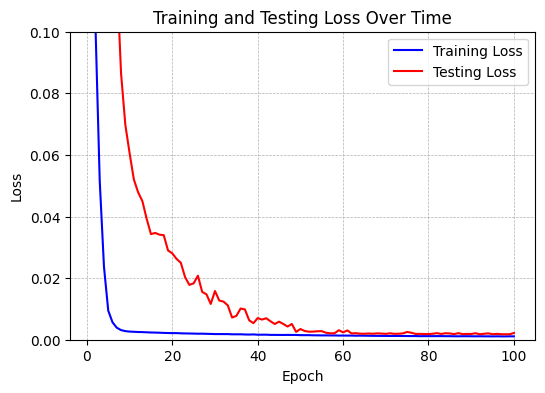

In [41]:
plot_losses(train_losses, test_losses)

## Predict and Compare on Test set

In [42]:
def predict_model(model, test_loader):
    model.eval()
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(model.fc.weight.device)
            y = y.to(model.fc.weight.device)
            
            outputs = model(X)
            
            y_pred.extend(outputs.cpu().numpy().flatten())
            y_true.extend(y.cpu().numpy().flatten())
    
    return np.array(y_true), np.array(y_pred)

y_true, y_pred = predict_model(model, test_loader)



### Important: Inverse the values back to original

MSE: 6.4219
MAE: 1.8496
RMSE: 2.5342


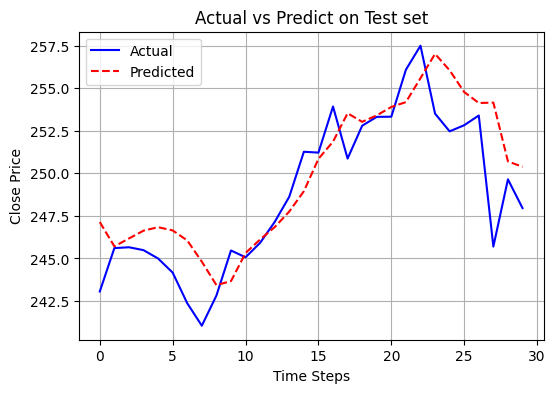

In [43]:
import numpy as np

num_features = close_train_np.shape[1]  

y_true_padded = np.zeros((len(y_true), num_features)) 
y_true_padded[:, 0] = y_true 

y_pred_padded = np.zeros((len(y_pred), num_features)) 
y_pred_padded[:, 0] = y_pred

y_true_original = scaler.inverse_transform(y_true_padded)[:, 0]  
y_pred_original = scaler.inverse_transform(y_pred_padded)[:, 0]


# Chart and calculate some metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

mse = mean_squared_error(y_true_original, y_pred_original)
mae = mean_absolute_error(y_true_original, y_pred_original)

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {np.sqrt(mse):.4f}')

plt.figure(figsize=(6, 4))
plt.plot(y_true_original, label='Actual', color='blue')
plt.plot(y_pred_original, label='Predicted', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.title('Actual vs Predict on Test set')
plt.legend()
plt.grid(True)
plt.show()